### Chatbot integrated with multiple tools using langgraph

* creating a chatbot with tool capabilities using tavily, arxiv, wikipedia search api's and other functions.

In [18]:
from dotenv import load_dotenv
import os
load_dotenv()

from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_tavily import TavilySearch
#!pip install langchain-tavily
#!pip install arxiv


In [19]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=500))
wikipedia

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAGs In Depth\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=500))

In [20]:
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500))
arxiv

ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500))

In [21]:
tavily= TavilySearch(max_results=3, verbose=True)
tavily

TavilySearch(verbose=True, max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))

In [22]:
tools = [wikipedia, arxiv, tavily]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'd:\\RAGs In Depth\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=500)),
 ArxivQueryRun(api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=500)),
 TavilySearch(verbose=True, max_results=3, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None))]

In [23]:
#model bind with tools
from langchain.chat_models import init_chat_model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
tools_model = model.bind_tools(tools)
tools_model

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000002BAF2566C10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002BAF2565190>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'fu

In [24]:
#defining state schema

from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List

class State(TypedDict):
    messages: Annotated[List, add_messages]

In [25]:
#defining node

def multiple_tools_llm(state:State):
    return {"messages": tools_model.invoke(state['messages'])}

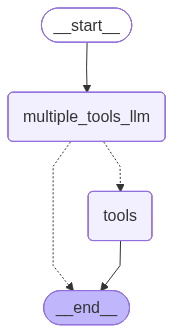

In [26]:
#designing graph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("multiple_tools_llm", multiple_tools_llm)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "multiple_tools_llm")
graph_builder.add_conditional_edges("multiple_tools_llm", tools_condition)


graph = graph_builder.compile()
graph


In [29]:
#invoking multiple tools graph
from pprint import pprint
response = graph.invoke({"messages": "give latest news about ai"})
for message in response['messages']:
    message.pretty_print()

content='{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2025/12/19/google-boomerang-year-20percent-ai-software-devs-hired-2025-ex-employees.html", "title": "Google boomerang year: 20% AI software devs hired 2025 ... - CNBC", "content": "Google has been racing to catch up in generative AI after a slow start that followed OpenAI\'s release of ChatGPT in late 2022. After fumbling a number of product rollouts, the company has bounced back this year, thanks to hefty investments in AI infrastructure and the success of its Gemini app. Google announced its latest model, Gemini 3, last month.\\n\\nAlphabet\'s stock price is up more than 60% this year, outperforming all of its megacap peers. [...] Some 20% of software engineers working on artificial intelligence that Google hired in 2025 were so-called boomerang employees, an increase from prior years, CNBC has learned. A Google spokesperson confirmed the statistic

In [30]:
response = graph.invoke({"messages": "say few lines about donald trump"})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

say few lines about donald trump
================================== Ai Message ==================================
Tool Calls:
  wikipedia (ftb0s466k)
 Call ID: ftb0s466k
  Args:
    query: Donald Trump
================================= Tool Message =================================
Name: wikipedia

Page: Donald Trump
Summary: Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States. A member of the Republican Party, he served as the 45th president from 2017 to 2021.
Born into a wealthy family in New York City, Trump graduated from the University of Pennsylvania in 1968 with a bachelor's degree in economics. He became the president of his family's real estate business in 1971, renamed it the Trump Org


In [33]:
response = graph.invoke({"messages": "arXiv:2512.16917"})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

arXiv:2512.16917
================================== Ai Message ==================================
Tool Calls:
  arxiv (712wqqcmw)
 Call ID: 712wqqcmw
  Args:
    query: arXiv:2512.16917
================================= Tool Message =================================
Name: arxiv

No good Arxiv Result was found
